In [10]:
pconnGrad = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/group-HCPS1200_atlas-GlasserTian_desc-subcorticalS2_conn.pconn.nii'

In [11]:
import nibabel as nib
from brainspace.gradient import GradientMaps
import pandas as pd
import numpy as np



def create_gradient(nifty, n, z_to_r):
    '''Create a pandas dataframe of n number of gradients from nifty file

    Loads .nii file with nibabel, creates a float type matrix
    Loads GradientMaps, and fits to the matrix
    Converts matrix to a pandas dataframe

    Parameters
    ----------
    nifty: .nii file type
        nifty file that will be read to create the gradients
    n: int
        The number of gradients to be created
    z_to_r: bool
        Determines whether hyperbolic tan is applied to the connectivity matrix

    Returns
    -------
    grad_df
        An array of values, rows x columns is ROIs x n number of gradients 

    ''' 

    # load the nii file with nibabel
    conn = nib.load(nifty)
    # create matrix with float data
    matrix = conn.get_fdata()
    # specify whether matrix converted to tanh matrix is true or false
    if z_to_r:
        matrix = np.tanh(matrix)
    # load GradientMaps
    gm = GradientMaps(n_components=n, random_state=0)
    # assert that the number of gradients requested does not exceed the regions of interest 
    max_grads = matrix.shape[0]
    assert n <= max_grads, 'Number of gradients exceeds rows in the matrix'
    # create the gradient as a matrix
    gm.fit(matrix)
    gradient = gm.gradients_
    # convert gradient to a pandas dataframe
    grad_df = pd.DataFrame(data = gradient, 
    columns=[f'grad{num + 1}' for num in range(gm.gradients_.shape[1])])
    return grad_df

grad_df = create_gradient(pconnGrad, 10, False)
grad_df

/home/a/arisvoin/lbassman/.conda/envs/nilearn_brainspace/lib/python3.8/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


,grad1,grad2,grad3,grad4,grad5,grad6,grad7,grad8,grad9,grad10
0,-0.436808,-0.586201,-1.171268,0.285311,-0.663547,0.283948,-1.128433,1.029141,-0.091408,0.346654
1,-0.085653,0.119678,-0.794615,0.246942,-0.575859,0.125472,-0.625248,1.288117,-0.522821,-0.424723
2,0.023722,0.013290,-1.568538,0.049606,1.511379,-0.414335,-0.112105,1.757560,0.611831,2.558381
3,-0.241167,-0.140379,-1.598294,0.034868,0.746537,-0.115298,-0.498338,1.622073,0.627149,2.563836
4,0.399223,0.765407,-0.329587,0.218939,-0.301677,-0.231552,0.422535,0.557144,-0.590380,-0.797721
...,...,...,...,...,...,...,...,...,...,...
387,-0.992845,-0.854515,-1.182763,0.268206,0.353054,0.030934,-0.462164,-0.618264,0.254425,-0.027699
388,-1.196666,-0.943769,0.219444,-0.516643,-0.091070,0.331441,0.918298,-0.496867,-0.197271,-0.110361
389,-0.053227,1.041225,-0.646104,0.302861,0.489087,-0.444075,0.190966,0.755612,-0.805701,0.124041
390,-0.569895,0.310687,0.956455,0.741705,-0.213892,-0.684013,-0.104681,-0.060808,0.005817,0.029052


In [12]:
from pathlib import Path

def write_df_column_to_pscalar_nib(df, pscalar_template, 
        to_filename = None, columns = None, labelname_column = None):
    ''' write a column from a pandas dataframe to pscalar file in nibabel 
     Parameters
    ----------
    df: pandas DataFrame
        Pandas dataframe containing data to write to file (with rows as parcels)
    
    pscalar_template: nibabel.Cifti2Image or filepath
        A pscalar.nii or pterseries.nii file or image to read the parcel axis from
    
    to_filename: str or path
        (optional) path (with extension .pscalar.nii) to write the output to
    columns: str or list
        (optional) list of columns to select for the pscalar image
    labelnames_column: str
        (optional) name of column that contains labelnames that should match the pscalar parcel names
        If this is given than data will be merged/aligned with the parcel axis before writing file.
    
    Returns
    -------
    pscalar_img: nibabel.Cifti2Image
        nibabel image of the pscalar output
        '''
           ## read the parcel axis from a template file
    if isinstance(pscalar_template, (str, Path)):
        pscalar_template = nib.load(pscalar_template)
    template_axis = pscalar_template.header.get_index_map(1)
    axis1_parcels = nib.cifti2.cifti2_axes.ParcelsAxis.from_index_mapping(template_axis)
    assert (isinstance(axis1_parcels, nib.cifti2.cifti2_axes.ParcelsAxis)), "Did not creat parcel axis"

    if labelname_column:
        axis_df = pd.DataFrame({'labelnames': axis1_parcels.name})
        df = df.merge(axis_df, 
            left_on = labelname_column, right_on = 'labelnames', how = 'right')
    
    ## grab columns if they exist
    if columns:
        df = df[columns]

    # grab the data column(s) and resphape them to the shape for pscalar 
    ## note that the dataobj shape should be (n_map, n_parcels)
    data_vals = df.transpose().values
    if len(data_vals.shape) == 1:
        data_vals = np.reshape(data_vals, (1,data_vals.shape[0]))
    
    ## assert that the number of parcels matches the length of the data array
    assert (axis1_parcels.size == len(df.index)), 'The number of parcels does not match the number of rows'

    ## create a scalar axis with names inlcuding the column names
    axis0_scalars = nib.cifti2.cifti2_axes.ScalarAxis(name = df.columns)
    
    ## combine all the bits together
    new_header = nib.Cifti2Header.from_axes((axis0_scalars, axis1_parcels))
    pscalar_img = nib.Cifti2Image(
        dataobj=data_vals, header = new_header)
    if to_filename:
        nib.cifti2.save(
            img = pscalar_img,filename=to_filename)

    return(pscalar_img)

In [563]:
import numpy as np
from enum import Enum
import nilearn.plotting as nplot
import nibabel as nib
from collections import namedtuple
import matplotlib.pyplot as plt
from pathlib import Path

CIFTI_GIFTI_MAP = {
    'CIFTI_STRUCTURE_CORTEX_LEFT': 'left',
    'CIFTI_STRUCTURE_CORTEX_RIGHT': 'right',
    'CortexLeft': 'left',
    'CortexRight': 'right'
}

NIFTI_INTENT_POINTSET = 1008


def gifti_get_mesh(gifti):
    '''
    Extract vertices and triangles from GIFTI surf.gii
    file
    Arguments:
        gifti (GiftiImage): Input GiftiImage
    '''

    v, t = gifti.agg_data(('pointset', 'triangle'))
    return v.copy(), t.copy()

def map_cifti_to_gifti(gifti, cifti, cifti_map_index = 0, fill_value = np.nan):
    '''
    Maps cifti data-array to gifti vertices to account
    for missing indices (i.e removal of medial wall)
    Arguments:
        gifti:      GIFTI surface mesh
        cifti:      CIFTI file to map [Series x BrainModel]
    Returns:
        verts:          Vertices of surface mesh
        trigs:          Triangles of surface mesh
        mapping_array:  An [Features x Vertices] mapping array pulled
                        from the CIFTI image
    '''

    # Validate and obtain CIFTI indices
    brain_models = None
    parcels = None
    for mi in cifti.header.mapped_indices:
        map_type = cifti.header.get_index_map(mi).indices_map_to_data_type
        if map_type == "CIFTI_INDEX_TYPE_BRAIN_MODELS":
            brain_models = cifti.header.get_axis(mi)
        if map_type == "CIFTI_INDEX_TYPE_PARCELS":
            parcels = cifti.header.get_axis(mi)

    # TODO: Implement logging + proper error
    if (brain_models is None) and (parcels is None):
        raise ValueError("CIFTI object does not contain BrainModelAxis!")

    # Validate and obtain GIFTI
    gifti_struct = None
    for d in gifti.darrays:
        if d.intent == NIFTI_INTENT_POINTSET:
            try:
                gifti_struct = d.metadata['AnatomicalStructurePrimary']
            except KeyError:
                raise ValueError(
                    f"{gifti.get_filename()} is not a surface mesh file!")

    if gifti_struct is None:
        raise ValueError(
            f"{gifti.get_filename()} contains no coordinate information!")

    # Now we need to map the coordinate of CIFTI onto GIFTI
    match_key = CIFTI_GIFTI_MAP[gifti_struct]
    
    # Extract vertices from GIFTI
    verts, trigs = gifti_get_mesh(gifti)
    
    for stucture in ['CIFTI_STRUCTURE_CORTEX_LEFT', 'CIFTI_STRUCTURE_CORTEX_RIGHT']:
        if CIFTI_GIFTI_MAP[stucture] == match_key:
            if parcels:
                mapping_array = surf_map_from_pscalar_image(cifti, 
                                                            stucture, 
                                                            map = cifti_map_index, 
                                                            fill_value = fill_value)
            if brain_models:
                mapping_array = surf_data_from_dense_cifti(cifti, 
                                                          stucture,
                                                          map_index = cifti_map_index,
                                                          fill_value = fill_value)
                
    
#     matched_bm = None
#     for struct, sl, bma in brain_models.iter_structures():
#         if CIFTI_GIFTI_MAP[struct] == match_key:
#             matched_bm = (struct, sl, bma)
#             break       
            
#     if matched_bm is None:
#         raise ValueError(
#             "No matching structures between CIFTI and GIFTI file!")

#     _, matched_verts, brain_model_ax = matched_bm
#     cifti_verts = brain_model_ax.vertex

#     # Map CIFTI vertices to GIFTI, setting non-filled values to NaN
#     mapping_array = np.empty((cifti.dataobj.shape[0], verts.shape[0]),
#                              dtype=cifti.dataobj.dtype)

#     # Write NaNs
#     mapping_array[:] = np.nan
#     try:
#         mapping_array[:, cifti_verts] = cifti.get_fdata()[:, matched_verts]
#     except IndexError:
#         raise ValueError("Cifti file contains vertices that are not indexed "
#                          "by the provided gifti file!")

    # Return mapping array
    return verts, trigs, mapping_array


def surf_data_from_dense_cifti(cifti, surf_name, map_index = "all", fill_value = np.nan):
    # the dscalar img is a filepath - load it
    if isinstance(cifti, (str, Path)):
        cifti = nib.load(cifti)
    axis = cifti.header.get_axis(1)
    data = cifti.get_fdata()
    if not map_index == "all":
        data = data[map_index,:]
    assert isinstance(axis, nib.cifti2.BrainModelAxis)
    for name, data_indices, model in axis.iter_structures():  # Iterates over volumetric and surface structures
        if name == surf_name:                                 # Just looking for a surface
            data = data.T[data_indices]                       # Assume brainmodels axis is last, move it to front
            vtx_indices = model.vertex                        # Generally 1-N, except medial wall vertices
            surf_data = np.zeros((vtx_indices.max() + 1,) + data.shape[1:], dtype=data.dtype)
            surf_data[:] = fill_value
            surf_data[vtx_indices] = data
            return surf_data
    raise ValueError(f"No structure named {surf_name}")


pconn = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/group-HCPS1200_atlas-GlasserTian_desc-subcorticalS2_conn.pconn.nii'


def surf_map_from_pscalar_image(pscalar_img, surface, map = 0, fill_value = np.nan):
    '''
    Read data from parcellated scalar or parcellated timeseries image into full surface map for plotting
    
    Parameters
    ----------
    pscalar_img: nibabel image, str or path
        nibabel image or filepath to image with extension .pscalar.nii
    
    surface: str
        Surface to load (either CIFTI_STRUCTURE_CORTEX_LEFT or CIFTI_STRUCTURE_CORTEX_RIGHT)
    
    map: str or integer
        Either the name of the scalar map or the column index (default: 0)
    fill_value: numeric value
        value to fill missing data non-parcel vertices on the surfuce (default: np.nan)
    Return
    ------
    surf_out: numpy data array (nvertices,)
        the parcellated scalar data mapped to the surface
    '''
    
    # the pscalar img is a filepath - load it
    if isinstance(pscalar_img, (str, Path)):
        pscalar_img = nib.load(pscalar_img)
    
    ## define map_number based on the "map" input arg
    if isinstance(map, str):
        if map == "all":
            map_number = list(range(len(pscalar_img.header.get_axis(1).name)))
        else:
            map_number = np.where(pscalar_img.header.get_axis(0).name==map)[0]
            if len(map_number) != 1:
                raise ValueError(f"the map name {map} was not present in the scalar axis names")
            map_number = int(map_number[0])
    else: 
        map_number = int(map)

    # grab the data
    data = pscalar_img.get_fdata()[map_number,:]
    if len(data.shape) == 1:
      data = data.reshape(data.shape[0],1)

    # grab the parcel axis (axis 1)
    axis = pscalar_img.header.get_axis(1)
    assert isinstance(axis, nib.cifti2.ParcelsAxis)

    # intialize an output array
    surf_out = np.zeros((axis.nvertices[surface], data.shape[1]))
    surf_out[:] = fill_value

    # iterate over the parcels writing the parcel values to the vertex indices
    for (parcel_data, parcel_vertices) in zip(data, axis.vertices):
        if surface in parcel_vertices:
            surf_out[parcel_vertices[surface],:] = parcel_data
    
    return surf_out


import pandas as pd
from matplotlib.colors import ListedColormap


def colormap_from_ciftiheader(dlabel_img):
    ''' reads the colormap from the cifti image LabelAxis for dense labels files (dlabel.nii)
    
    Parameters
    ----------
    dlabel_image: str, path or nibabel.cifti2 image
        input label file or image
        
    Returns
    -------
    cm : matplotlib colormap
        matplotlib colormap object read with the color look up table colours
    '''
    if isinstance(dlabel_img, (str, Path)):
            dlabel_img = nib.load(dlabel_img)
        # read the labeltable from the header
    label_axis = dlabel_img.header.get_axis(0)
    assert isinstance(label_axis, nib.cifti2.cifti2_axes.LabelAxis)
    label_colours = [val[1] for val in label_axis.label[0].values()]
    cm = ListedColormap(
        name = label_axis.name[0], 
        colors = label_colours, 
        N=max(label_axis.label[0].keys())+1)
    return cm

    
def plot_cifti_surf_montage(left_surf, right_surf, cifti_map, 
                            bg_cifti_map = None, 
                            views = ["lateral", "medial", "medial", "lateral"],
                            hemis = ["left", "left", "right", "right"],
                            bg_cifti_map_index = "all", 
                            colormap = None, 
                            darkness = 0.8,
                            add_view_titles = True,
                            to_filename = None):
    """
    plotting montage of both hemispheres
    
    Generate a surface visualization
    Parameters
    --------
    left_surf: str or Path
      
    bg_cifti_map :
      (optional) Cifti file containing background map data (usually sulci depth)
    Returns:
        runtime: Resultant runtime object
    """

    from mpl_toolkits import mplot3d  # noqa: F401

    assert len(views) == len(hemis), f"number of views ({views}) is not equal to the number of hemipheres ({hemis})"
        
    Hemispheres = namedtuple("Hemispheres", ["left", "right"])
    vmin = None
    vmax = None

    l_surf = nib.load(left_surf)
    r_surf = nib.load(right_surf)
    num_views = len(views)
    num_maps = 1

    if cifti_map:
        cifti_map = nib.load(cifti_map)
        lv, lt, lm = map_cifti_to_gifti(l_surf, cifti_map, cifti_map_index = bg_cifti_map_index)
        rv, rt, rm = map_cifti_to_gifti(r_surf, cifti_map, cifti_map_index = bg_cifti_map_index)

        map_hemi = Hemispheres(left=(lv, lt, lm), right=(rv, rt, rm))
        num_maps = lm.shape[1]
        
        if colormap == "read_from_cifti":
            colormap = colormap_from_ciftiheader(cifti_map)
        else:
            vmin, vmax = np.nanpercentile(cifti_map.get_fdata(), [2, 98])
    else:
        # Use vertices and triangles from Mesh
        lv, lt = gifti_get_mesh(l_surf)
        rv, rt = gifti_get_mesh(r_surf)
        map_hemi = Hemispheres(left=(lv, lt, None), right=(rv, rt, None))
        

    if bg_cifti_map:
        bg_map = nib.load(bg_cifti_map)
        _, _, l_bg = map_cifti_to_gifti(l_surf, bg_map, fill_value = 0)
        _, _, r_bg = map_cifti_to_gifti(r_surf, bg_map, fill_value = 0)
        bg_hemi = Hemispheres(left=l_bg, right=r_bg)
    else:
        bg_hemi = Hemispheres(left=None, right=None)

    # Construct figure
    w, h = plt.figaspect(num_maps / (num_views))
    fig, axs = plt.subplots(num_maps,
                            num_views,
                            subplot_kw={'projection': '3d'},
                            figsize=(w, h))
    fig.set_facecolor("white")
    fig.tight_layout()
    for i, a in enumerate(axs.flat):
        a.set_facecolor("white")

        # Get row (map)
        i_map = i // (num_views)

        # Get column
        i_view = (i) % (num_views)
        view = views[i_view]

        # Get hemisphere
        hemi = hemis[i_view]
        if hemi == "left":
            display_map = map_hemi.left
            display_bg = bg_hemi.left
        elif hemi == "right":
            display_map = map_hemi.right
            display_bg = bg_hemi.right
        else:
            raise ValueError('hemis must be "left" or "right"')
        
        if add_view_titles: a.set_title(f'{hemi} {view}')
        # Plot
        v, t, m = display_map
        nplot.plot_surf([v, t],
                        surf_map=m,
                        bg_map= display_bg,
                        cmap=colormap,
                        axes=a,
                        hemi=hemi,
                        view=view,
                        bg_on_data=True,
                        vmin = vmin,
                        vmax = vmax,
                        darkness=darkness)
    
    if not to_filename:    
        plt.draw()
    else:
        plt.savefig(to_filename)
    
    return(plt)


get_ipython().run_line_magic('matplotlib', 'inline')


dlabel_file = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR_den-32k_atlas-Glasser2016Tian2019_desc-subcortexS2_dseg.dlabel.nii'



label_axis = nib.load(dlabel_file).header.get_axis(0)
label_colours = [val[1] for val in label_axis.label[0].values()]
label_keys = label_axis.label[0].keys()


max(label_keys)

# %%
from matplotlib.colors import ListedColormap
cm = colormap_from_ciftiheader()

# %%
import matplotlib.pyplot as plt
x = np.array(list(label_keys))
y = np.ones(len(label_colours)) 

plt.figure(figsize=(20,1))
plt.scatter(x, y, marker='o', s = 100, c=x, cmap = cm)

# Show the boundary between the regions:
plt.show()


lv, lt, lm = map_cifti_to_gifti(nib.load('/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii'), 
                                nib.load(dlabel_file), cifti_map_index = "all")


label_axis.name[0]


yeo_cm = colormap_from_ciftiheader('/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR_den-32k_atlas-Ji2019_desc-12net_dseg.dlabel.nii')
x = np.array(range(14))
y = np.ones(14) 

plt.figure(figsize=(20,1))
plt.scatter(x, y, marker='o', s = 100, c=x, cmap = yeo_cm)

# Show the boundary between the regions:
plt.show()


surf_map_from_pscalar_image(pconn, "CIFTI_STRUCTURE_CORTEX_LEFT", map = 'aHIP-rh', fill_value = np.nan).shape



cifti_map = 'HCP_grads.pscalar.nii'
dcifti = nib.load(cifti_map)



ddata = surf_data_from_dense_cifti(dcifti, "CIFTI_STRUCTURE_CORTEX_LEFT", map_index = "all", fill_value = np.nan)


views = ['medial']
num_views = len(views)
num_maps = 2
mirror_views = True

if mirror_views == True:
    all_views = views + views[::-1]
else:
    all_views = views*2
    
w, h = plt.figaspect(num_maps / (num_views * 2))
fig, axs = plt.subplots(num_maps,
                        len(all_views),
                        subplot_kw={'projection': '3d'},
                        figsize=(w, h))
for i, a in enumerate(axs.flat):

        # Get row (map)
        i_map = i // len(all_views)

        # Get column
        i_view = (i) % len(all_views)
        #i_view = (i // (i_map + 1)) % num_views
        view = all_views[i_view]

        # Get hemisphere
        hemi = i_view // num_views
        if hemi == 0:
            hemi = "left"
        else:
            hemi = "right"
        print(f'{i} row/colum: {i_map}/{i_view} {view} {hemi}')

TypeError: colormap_from_ciftiheader() missing 1 required positional argument: 'dlabel_img'

In [565]:
from scipy.spatial import procrustes
import nibabel as nib
from brainspace.gradient import GradientMaps
import pandas as pd
import numpy as np



def calc_aligned_gradient(input_timeseries, template_gradients, kernel = 'cosine', alignment = 'procrustes'):
    '''Align a set of gradients to a template series of gradients using procrustes, returns as dataframe

    Loads GradientMaps, and makes same number of gradients as in the template
    Fits the desired gradients to the reference template
    Converts to pandas dataframe with labelled columns

    Parameters
    ----------
    input_timeseries (ndarray or list of arrays, shape = (n_ROIs, n_timepoints))
    template_gradients, shape =  (n_rois, n_gradients)


    Returns
    -------
    grad_df_aligned
        An array of values, rows x columns is ROIs x n number of gradients 

    ''' 
    # load GradientMaps
    gm = GradientMaps(n_components=template_gradients.shape[1], random_state=0, alignment = 'procrustes', kernel=kernel)
    # assert that the number of gradients requested does not exceed the regions of interest 
    # create the gradient as a matrix
    gm.fit(input_timeseries, reference = template_gradients)
    gradient = gm.aligned_
    # convert gradient to a pandas dataframe
    grad_df_aligned = pd.DataFrame(data = gradient, 
    columns=[f'grad{num + 1}' for num in range(gm.aligned_.shape[1])])
    return grad_df_aligned


In [567]:
import os


def get_List_Of_Files(dir_Name):
    '''Creates a list of files and sub directories from path
    Creates empty list
    Uses os to iterate over all subdirectories
    
    Parameters
    -----------
    dir_Name: str
        Path to the directory containing desired files
        
    Returns 
    --------
    List of all files in a given directory including subdirectories
    ''' 
    # names in the given directory 
    list_Of_File = os.listdir(dir_Name)
    allFiles = list()
    # Iterate over all the entries
    for entry in list_Of_File:
        # Create full path
        full_Path = os.path.join(dir_Name, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(full_Path):
            allFiles = allFiles + get_List_Of_Files(full_Path)
        else:
            allFiles.append(full_Path)
                
    return allFiles

path = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/2mm_noGSR'

all_files = get_List_Of_Files(path)                        # get every file in directory of all subject files


EA_filter = ['1D','RS_2mm','lock']                         # parameters to filter for only task emp files 

RS_filter = ['1D', 'EA_2mm_noGSR', 'lock']                 # parameters to filter for only rest files

EA_filter_data = [x for x in all_files if
              all(y not in x for y in EA_filter)]          # creates a list of all the paths to EA data for all participants

RS_filter_data = [x for x in all_files if
              all(y not in x for y in RS_filter)]          # creates a list of all the paths to RS data for all participants


EA_dfs = list()                               #list of all the pandas-read emp files
for filename in EA_filter_data:
     df = pd.read_csv(filename, header=None)
     EA_dfs.append(df)
    
RS_dfs = list()                               #list of all the pandas-read rest files
for filename in RS_filter_data:
     df = pd.read_csv(filename, header=None)
     RS_dfs.append(df)

In [19]:
aligned_EA_gradients = list()            # empty list to hold the procrustes algined emp/rest/concatenated gradients 

for i in range(len(EA_dfs)):             # creates aligned emp/rest/concatenated gradients for all subjects
    aligned = calc_aligned_gradient(EA_dfs[i].values, grad_df.values)
    aligned_EA_gradients.append(aligned)
    
aligned_RS_gradients = list()

for i in range(len(RS_dfs)):
    aligned = calc_aligned_gradient(RS_dfs[i].values, grad_df.values)
    aligned_RS_gradients.append(aligned)
    

aligned_concat_gradients = list()               ## will not work properly without last 8 RS
concat_grad = list()

for i in range(len(RS_dfs)):     
    concat_grads = pd.concat([EA_dfs[i],RS_dfs[i]], axis=1)    #concatenates each subject's emp and rest gradients 
    concat_grad.append(concat_grads)
    aligned = calc_aligned_gradient(concat_grad[i].values, grad_df.values)
    aligned_concat_gradients.append(aligned)  

In [23]:
EA_subjects = list()            # empty list to hold all the subject IDs

for i in range(len(EA_filter_data)):      # getting subject IDs from directory above each file name
    EA_subjects_list = os.path.basename((os.path.dirname(EA_filter_data[i])))
    EA_subjects.append(EA_subjects_list)
    
RS_subjects = list()

for i in range(len(RS_filter_data)):
    RS_subjects_list = os.path.basename((os.path.dirname(RS_filter_data[i])))
    RS_subjects.append(RS_subjects_list)

In [500]:
subject_list= list()               #empty list for the large concatenated file of all information
subject_list_df = list()           #creates one column dataframe to be horizontally concat with file

for i in range(len(EA_filter_data)):
    subject=[EA_subjects[i]]*392
    subject_list.append(subject)

    subject_list_dfs=pd.DataFrame(subject_list[i],
                                columns=['Subject ID'])
    subject_list_df.append(subject_list_dfs)
    
ROIs = aligned_EA_pscalar.header.get_axis(1).name         #single column grad of the ROI for each value in the concat grad

ROIs_list = pd.DataFrame(ROIs, 
                         columns=['ROI']) 

EA_list = ['EA'] * 392                  #specifies whether value in large gradient is rest or emp

EA_list_df=pd.DataFrame(EA_list,
                       columns=['EA or RS'])

RS_list = ['RS'] * 392

RS_list_df=pd.DataFrame(RS_list,
                       columns=['EA or RS'])

In [501]:
EA_concatenated = list()         #creates master file of all emp or rest files w subject ID, ROI, and EA/RS specified

for i in range(len(EA_filter_data)):
    EA_concat=pd.concat([aligned_EA_gradients[i],ROIs_list,EA_list_df,subject_list_df[i]],axis=1)
    EA_concatenated.append(EA_concat)
    
EA_concat = pd.concat(EA_concatenated)

RS_concatenated = list()

for i in range(len(RS_filter_data)):
    RS_concat=pd.concat([aligned_RS_gradients[i],ROIs_list,RS_list_df,subject_list_df[i]],axis=1)
    RS_concatenated.append(RS_concat)
    
RS_concat = pd.concat(RS_concatenated)

In [503]:
all_concat=pd.concat([EA_concat,RS_concat])        #vertically concatenates rest and emp dataframes to contain all data in one

path = '/scratch/a/arisvoin/lbassman/spins_concatenated_full'    #writes dataframe to csv in scratch 

all_concat.to_csv(path_or_buf=path)

In [490]:
root_path = '/scratch/a/arisvoin/lbassman/spins_gradients'    #creates folders for every subject ID
EA_folders = EA_subjects
for folder in EA_folders:
    os.mkdir(os.path.join(root_path,folder))

In [4]:
import os

root_path = '/scratch/a/arisvoin/lbassman'      #creates sub-folder to hold all subject folders 
folder = 'spins_gradients'
os.mkdir(os.path.join(root_path,folder))

In [494]:
aligned_EA_pscalars = list()       #writes every emp gradient to a pscalar

for i in range (len(EA_subjects)):

    aligned_EA_pscalar = write_df_column_to_pscalar_nib(aligned_EA_gradients[i], pconnGrad, to_filename= f'/scratch/a/arisvoin/lbassman/spins_gradients/{EA_subjects[i]}/{EA_subjects[i]}_task-emp_atlas-glassertian_gradients.pscalar.nii')
    aligned_EA_pscalars.append(aligned_EA_pscalar)

In [495]:
aligned_RS_pscalars = list()       #writes every rest gradient to a pscalar

for i in range (len(RS_subjects)):

    aligned_RS_pscalar = write_df_column_to_pscalar_nib(aligned_RS_gradients[i], pconnGrad, to_filename= f'/scratch/a/arisvoin/lbassman/spins_gradients/{RS_subjects[i]}/{RS_subjects[i]}_task-rest_atlas-glassertian_gradients.pscalar.nii')
    aligned_RS_pscalars.append(aligned_RS_pscalar)

In [497]:
aligned_concat_pscalars = list()    #writes every concatenated emp/rest gradient to a pscalar

for i in range (len(RS_subjects)):

    aligned_RS_pscalar = write_df_column_to_pscalar_nib(aligned_concat_gradients[i], pconnGrad, to_filename= f'/scratch/a/arisvoin/lbassman/spins_gradients/{RS_subjects[i]}/{RS_subjects[i]}_concatenated_atlas-glassertian_gradients.pscalar.nii')
    aligned_RS_pscalars.append(aligned_RS_pscalar)

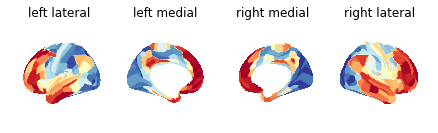

In [571]:
#plotting one gradient for one subject

plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = '/scratch/a/arisvoin/lbassman/spins_gradients/sub-MRC0057/sub-MRC0057_task-emp_atlas-glassertian_gradients.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 0,
                        colormap = "RdYlBu", 
                        darkness = 0,
                        to_filename = None)


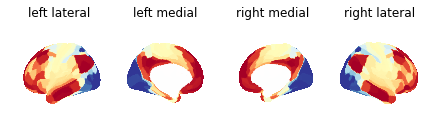

In [526]:
#plotting the first 5 template gradients 

plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = 'HCP_grads.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 0,
                        colormap = "RdYlBu", 
                        darkness = 0,
                        to_filename = None)

#plt2.savefig('HCP_template_gradient1.png')

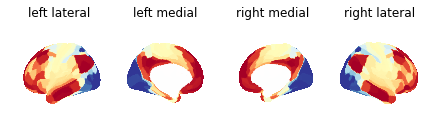

In [557]:
#testing one gradient with z_to_r applied in create_gradient

plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = 'HCP_grad_tanh.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 0,
                        colormap = "RdYlBu", 
                        darkness = 0,
                        to_filename = None)

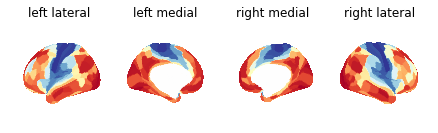

In [519]:
plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = 'HCP_grads.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 1,
                        colormap = "RdYlBu", 
                        darkness = 0,
                        to_filename = None)

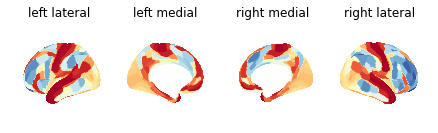

In [415]:
plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = 'HCP_grads.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 2,
                        colormap = "RdYlBu", 
                        darkness = 0,
                        to_filename = None)

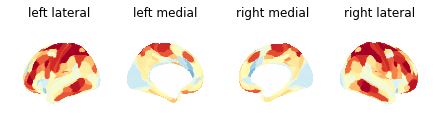

In [416]:
plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = 'HCP_grads.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 3,
                        colormap = "RdYlBu", 
                        darkness = 0,
                        to_filename = None)

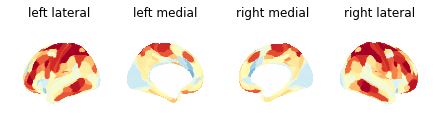

In [569]:
plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = 'HCP_grad_tanh.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 3,
                        colormap = "RdYlBu", 
                        darkness = 0,
                        to_filename = None)

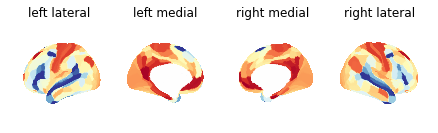

In [564]:
plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = 'HCP_grads.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 4,
                        colormap = "RdYlBu", 
                        darkness = 0,
                        to_filename = None)

<AxesSubplot:xlabel='grad1', ylabel='grad2'>

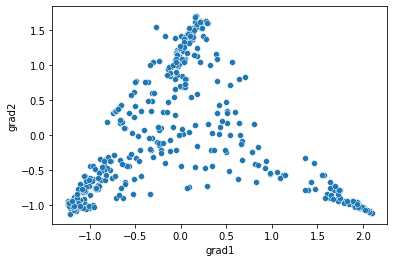

In [524]:
sns.scatterplot(data = grad_df, x = "grad1", y = "grad2")